# 0. Activate Comet_ML

* **[Project experiments](https://www.comet.ml/etokone/fmri-la5c-study/view/new/experiments)** 

In [1]:
# Load variables
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Initialize experiment
from comet_ml import Experiment

experiment = Experiment(
    api_key=os.getenv('API_KEY'),
    project_name=os.getenv('PROJECT_NAME'),
    workspace=os.getenv('WORKSPACE'),
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etokone/fmri-la5c-study/77549b2bee0b4a0ca5149458712f5926



# 1. Explore the data

In [3]:
!tree -L 1 '../data/ds000030/derivatives/fmriprep'

../data/ds000030/derivatives/fmriprep
├── dataset_description.json
├── sub-10171
├── sub-10292
├── sub-10365
├── sub-10565
├── sub-11106
├── sub-11122
├── sub-11131
├── sub-50010
├── sub-50035
├── sub-50047
├── sub-50048
├── sub-50052
├── sub-50067
├── sub-50075
├── sub-50077
├── sub-50081
└── sub-50083

17 directories, 1 file


In [4]:
!tree '../data/ds000030/derivatives/fmriprep/sub-50035/'

../data/ds000030/derivatives/fmriprep/sub-50035/
├── anat
│   ├── sub-50035_desc-aparcaseg_dseg.nii.gz
│   ├── sub-50035_desc-aseg_dseg.nii.gz
│   ├── sub-50035_desc-brain_mask.json
│   ├── sub-50035_desc-brain_mask.nii.gz
│   ├── sub-50035_desc-preproc_T1w.json
│   ├── sub-50035_desc-preproc_T1w.nii.gz
│   ├── sub-50035_dseg.nii.gz
│   ├── sub-50035_from-fsnative_to-T1w_mode-image_xfm.txt
│   ├── sub-50035_from-T1w_to-fsnative_mode-image_xfm.txt
│   ├── sub-50035_label-CSF_probseg.nii.gz
│   ├── sub-50035_label-GM_probseg.nii.gz
│   ├── sub-50035_label-WM_probseg.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-brain_mask.json
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-preproc_T1w.json
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_dseg.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz
│   ├── sub-50035_space-MNI152N

In [5]:
# Explore Bids object
import bids

layout = bids.BIDSLayout('../data/ds000030/derivatives/fmriprep/',
                        config=['bids', 'derivatives'])

print(f'List of subjects: {layout.get_subjects()} \n\nList of tasks: {layout.get_tasks()}')

List of subjects: ['10292', '11131', '50081', '50047', '10171', '50010', '50035', '11106', '50048', '50052', '50077', '50083', '50075', '50067', '10565', '11122', '10365'] 

List of tasks: ['rest']


In [6]:
import os 

from src.utils import extract_extension_files, pull_vox_ts, plot_ts
from src.utils import extract_confounds

from nilearn import image as nimg
from nilearn import plotting as nplot
from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [7]:
# extension="nii.gz" doesn`t work (I dont know why)

fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = bids.BIDSLayout('../data/ds000030/derivatives/fmriprep/',
                        config=['bids', 'derivatives'])

T1w_files = layout.get(subject='50048',
                       datatype='anat', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       extension="nii.gz",
                      return_type='file')

brainmask_files = layout.get(subject='50048',
                             datatype='anat', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                             extension="nii.gz",
                            return_type='file')

func_files = layout.get(subject='50048',
                        datatype='func', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       extension="nii.gz",
                       return_type='file')

func_mask_files = layout.get(subject='50048',
                             datatype='func', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                             extension="nii.gz",
                            return_type='file')
print(T1w_files)

[]


In [8]:
# Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = bids.BIDSLayout(fmriprep_dir,
                        config=['bids', 'derivatives'])

# Get T1w preprocessed anatomical files
T1w_files = layout.get(subject='50048',
                       datatype='anat', desc='preproc',
                       space='MNI152NLin2009cAsym',
                      return_type='file')
T1w_files = extract_extension_files(T1w_files)

# Get binary brain mask
brainmask_files = layout.get(subject='50048',
                             datatype='anat', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
brainmask_files = extract_extension_files(brainmask_files)

print(len(T1w_files))

1


In [9]:
# Load images
bm = brainmask_files[0]
t1_img = T1w_files[0]

bm_img = nimg.load_img(bm)
t1_img = nimg.load_img(t1_img)

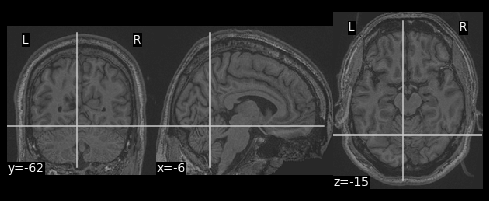

In [10]:
nplot.plot_anat(t1_img)


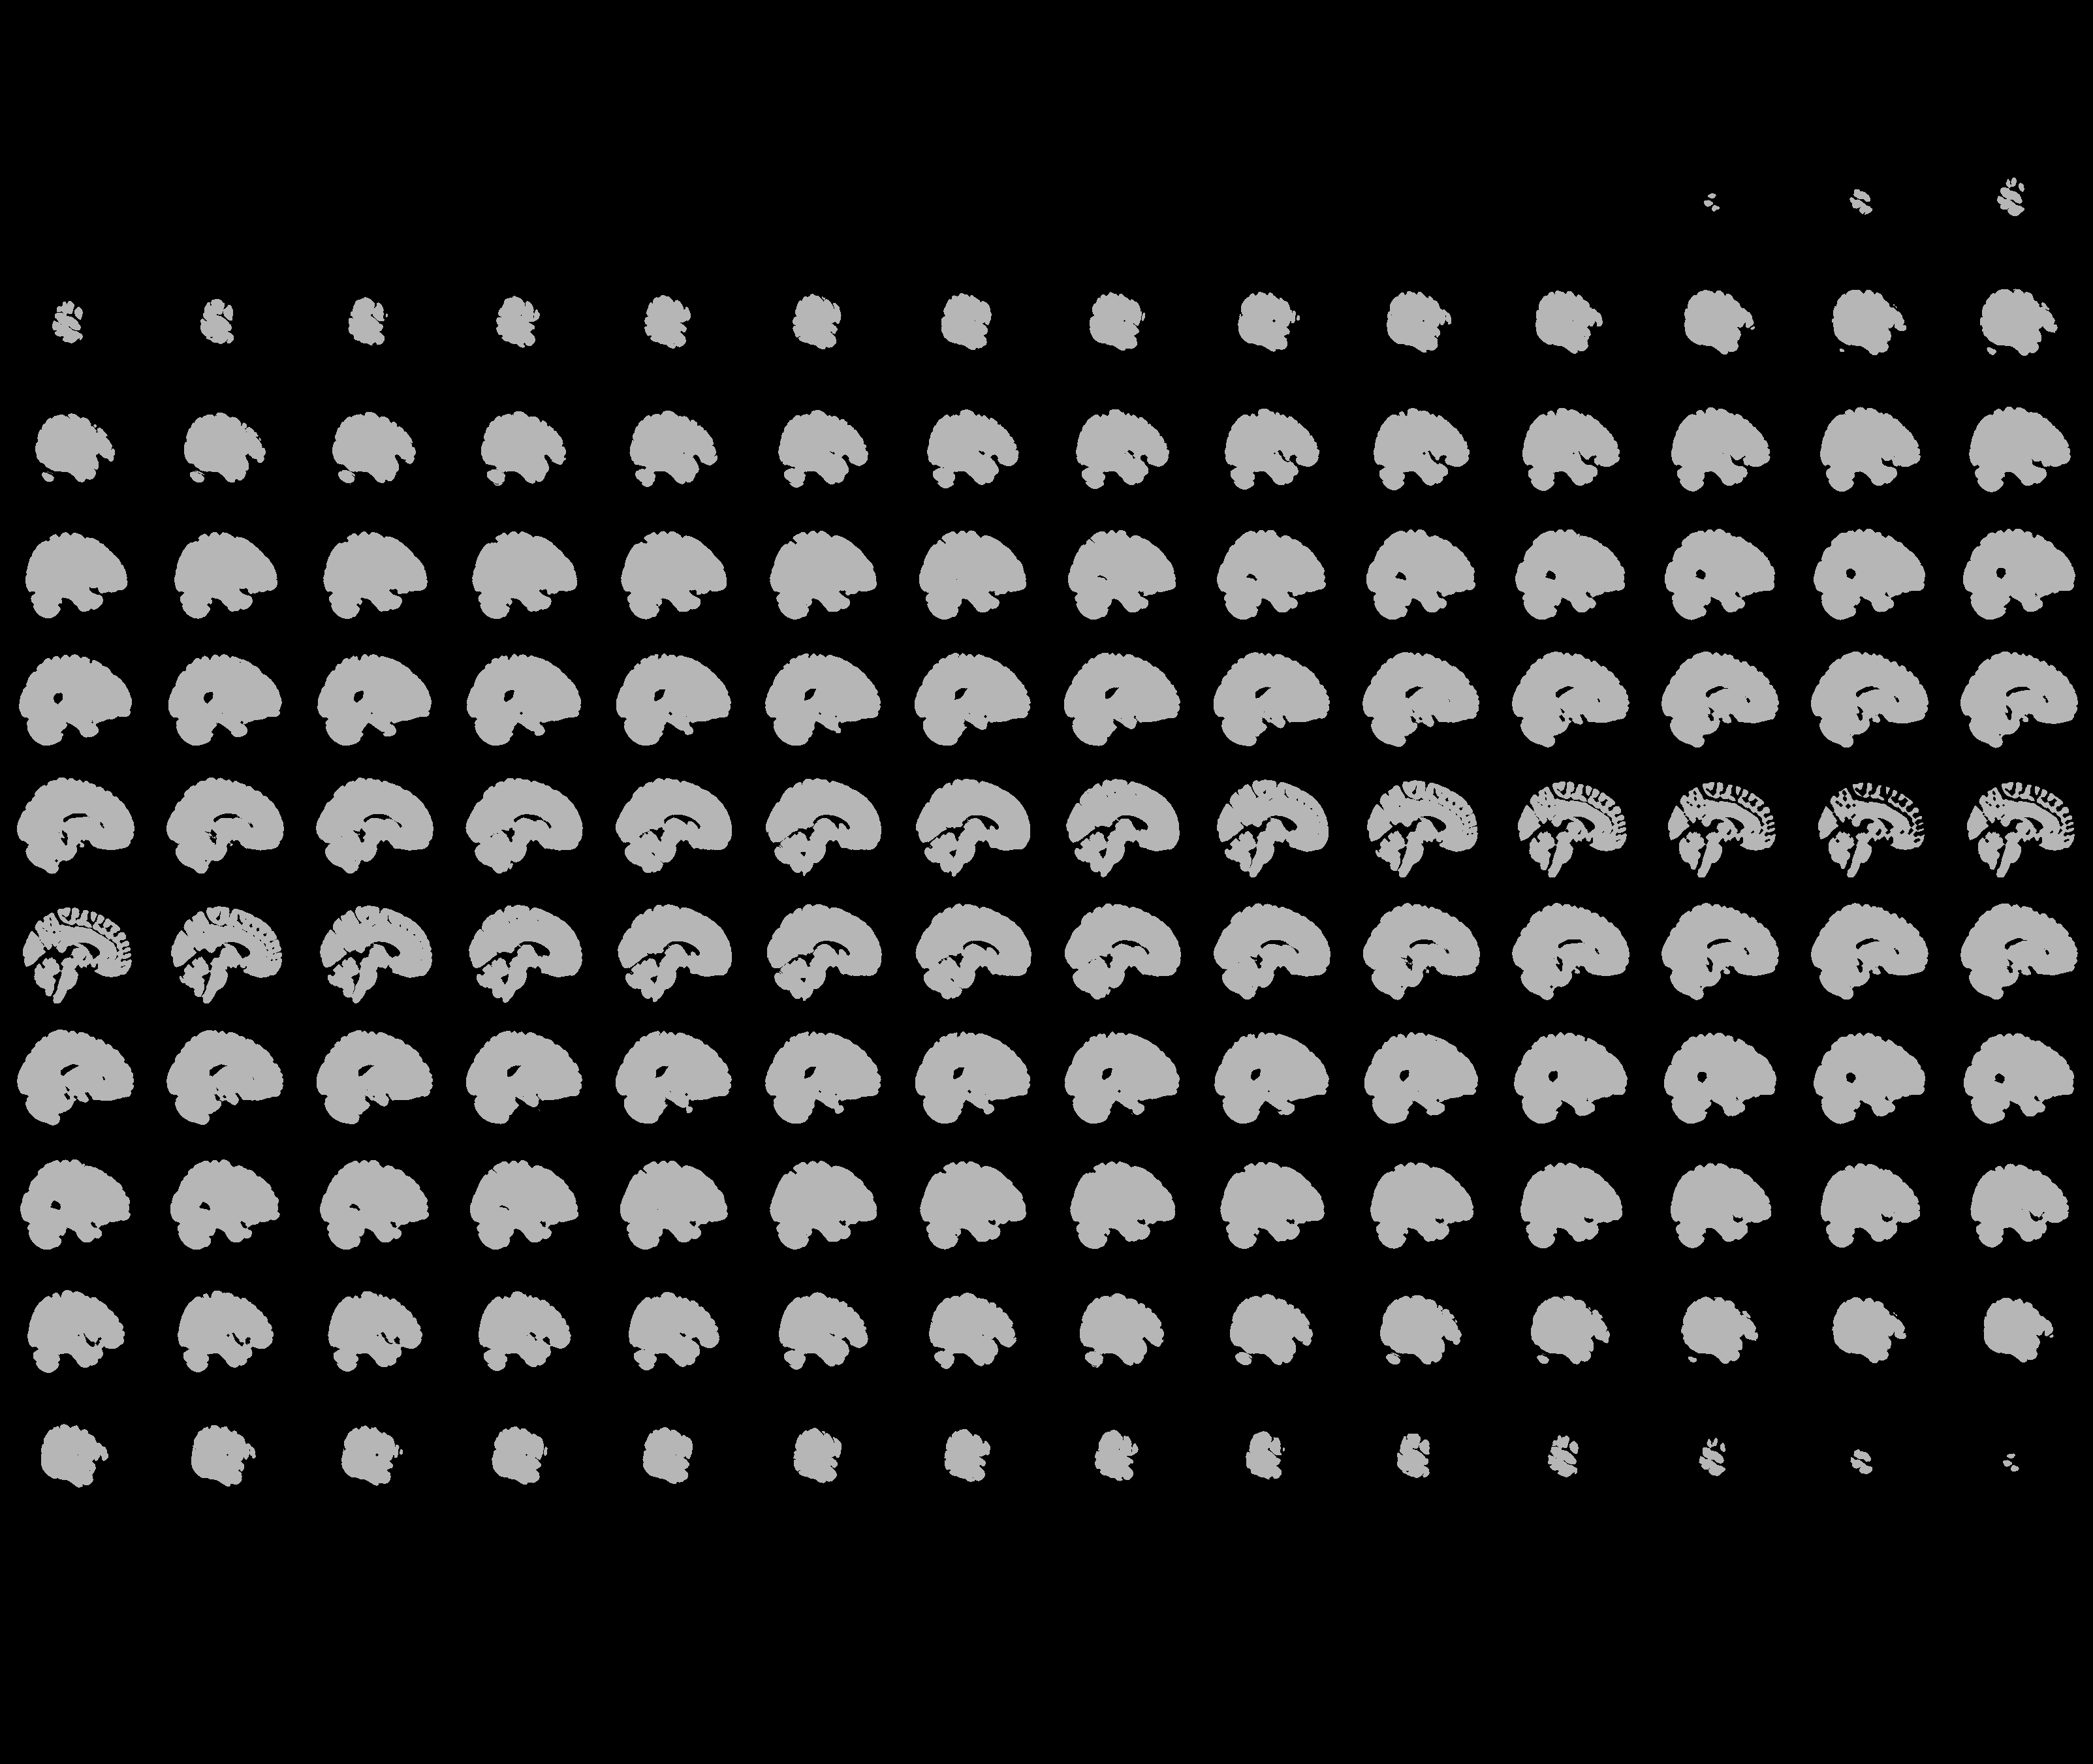
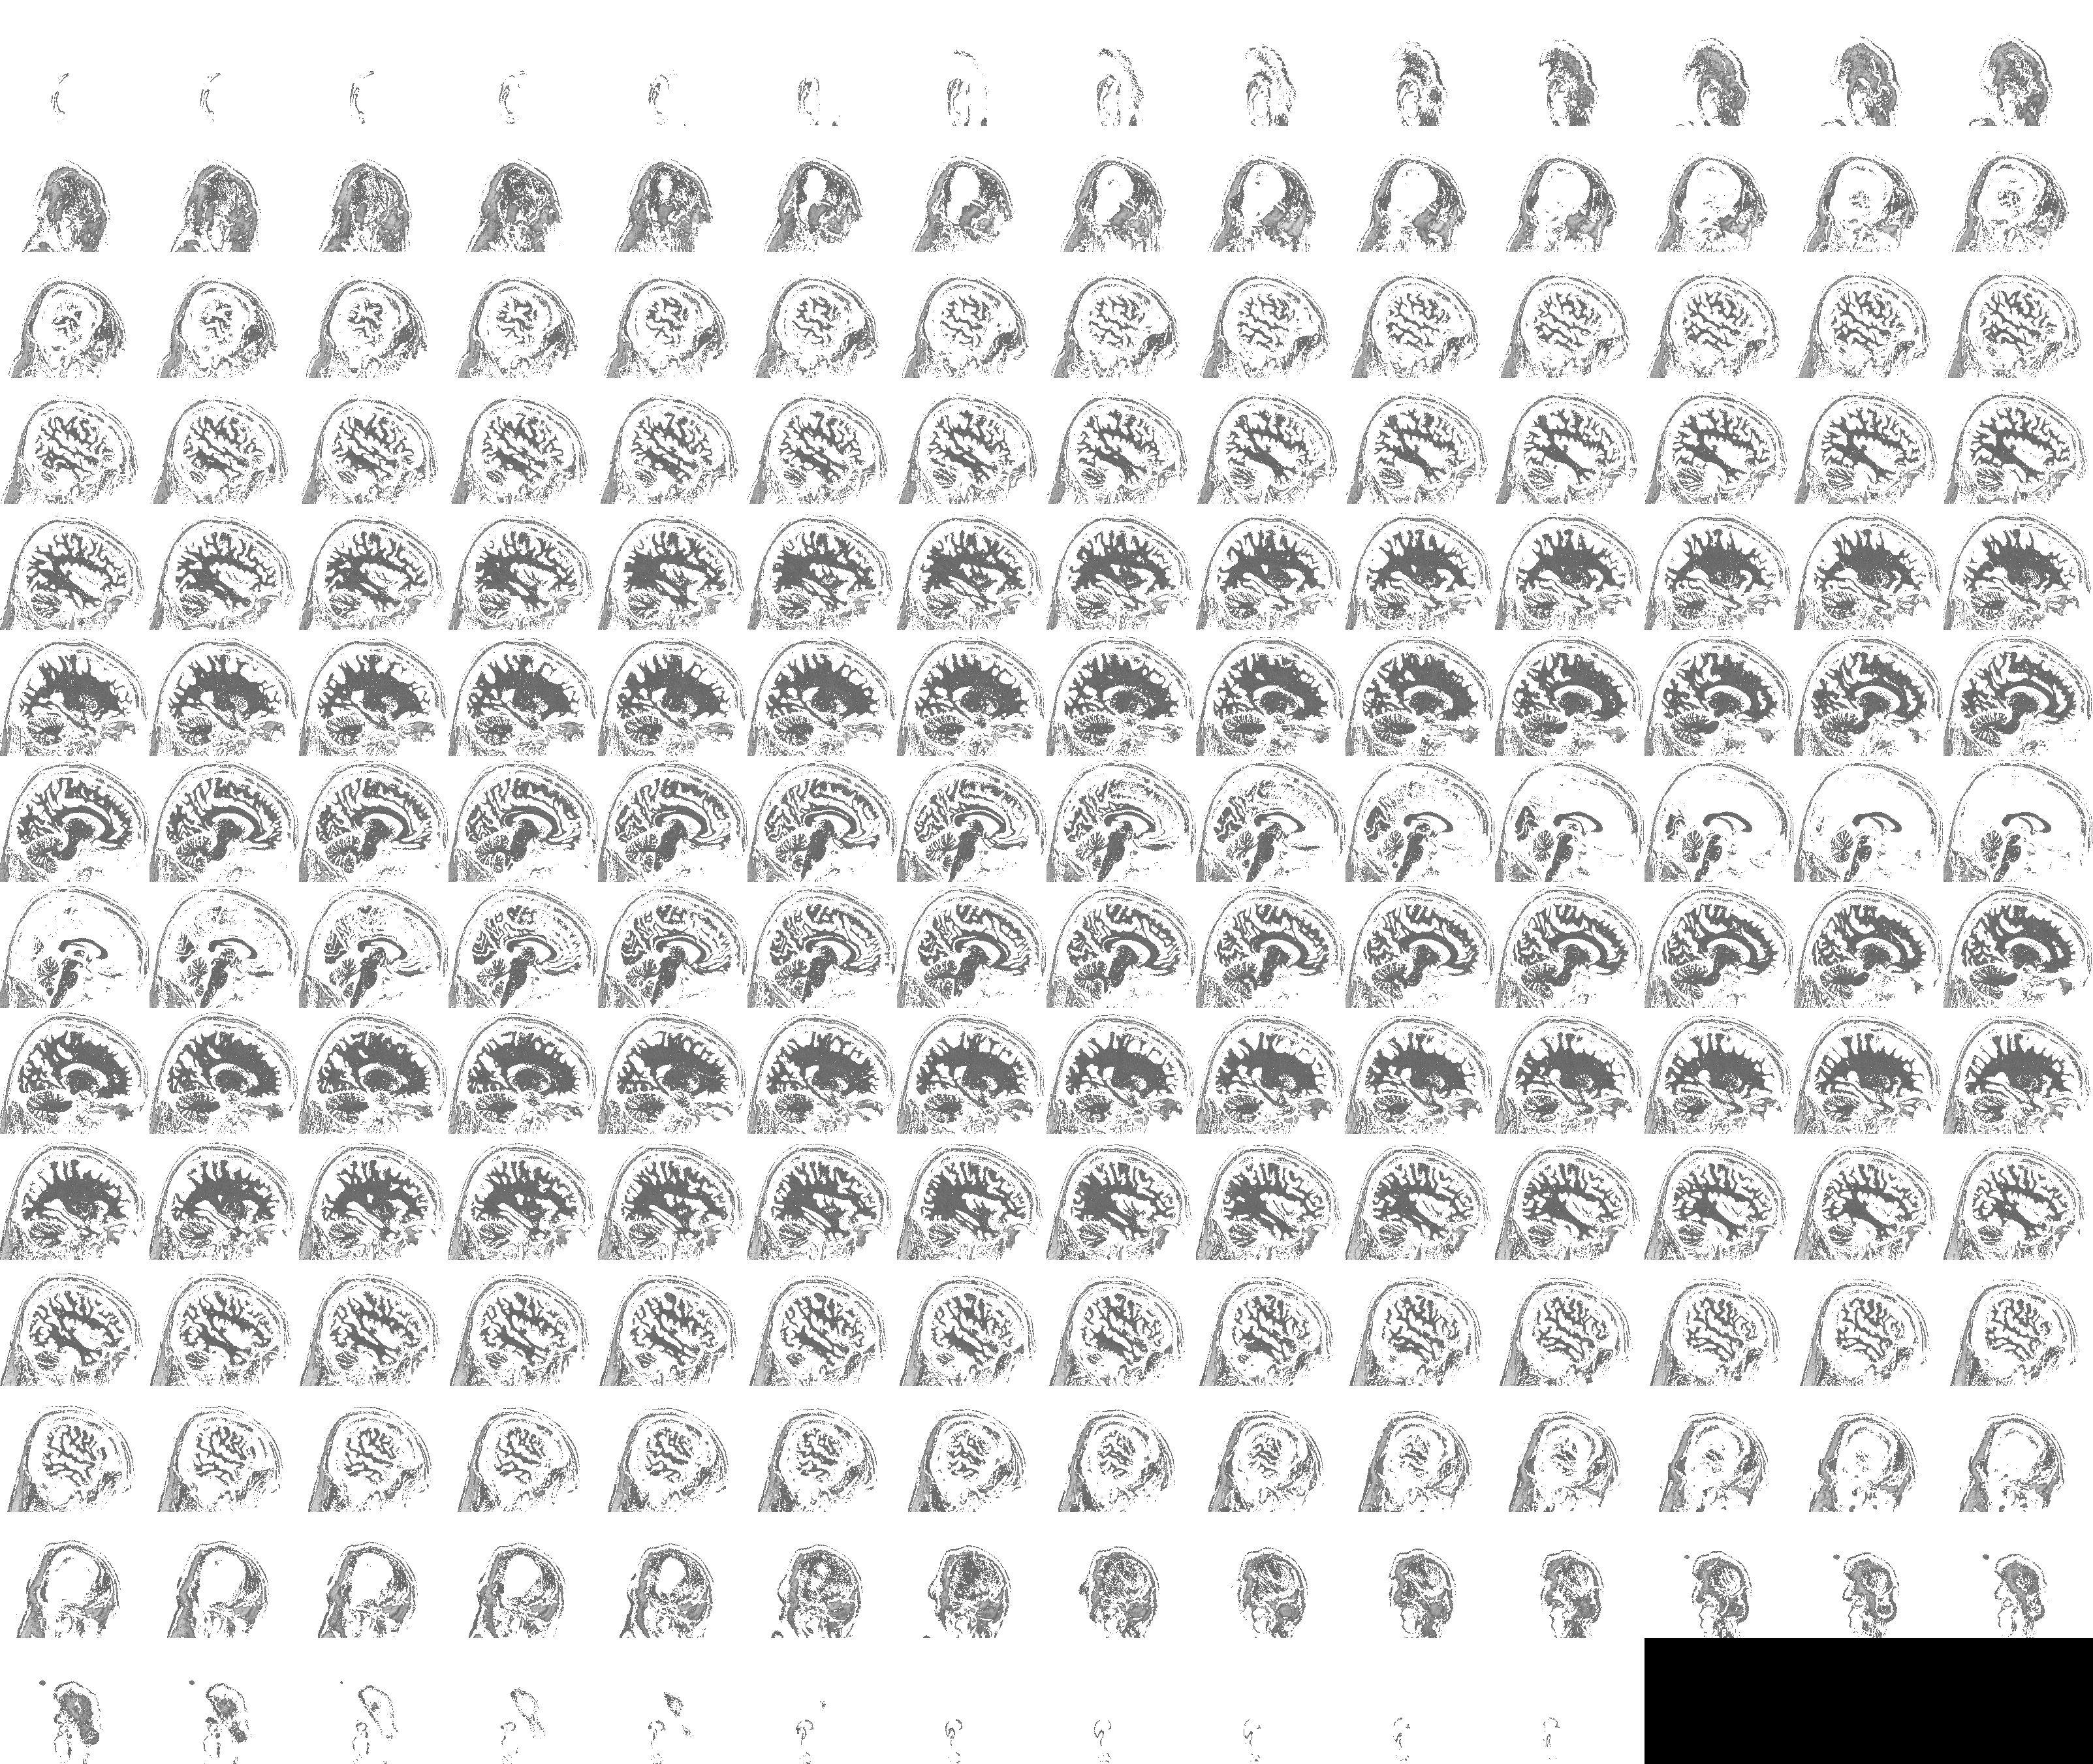

In [11]:
nplot.view_img(t1_img,
               bg_img=bm_img,
               cmap='Greys_r',
               symmetric_cmap=False,
               threshold="auto")

# 2. fMRI data
## 2.1. Visualize data

In [12]:
# Get preprocessed functional files
func_files = layout.get(subject='50048',
                        datatype='func', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       return_type='file')
func_files = extract_extension_files(func_files)

func_mask_files = layout.get(subject='50048',
                             datatype='func', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
func_mask_files = extract_extension_files(func_mask_files)

In [13]:
# Load func image
func_mni = func_files[0]
func_mni_img = nimg.load_img(func_mni)

In [14]:
# Check 4 dimantions
func_mni_img.shape

(65, 77, 49, 152)

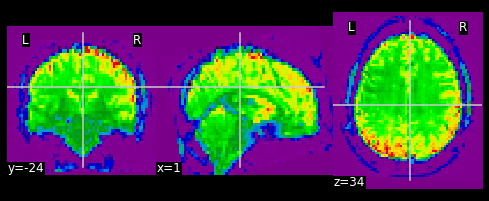

In [15]:
# Pull the first 5th TR
func_vol5 = func_mni_img.slicer[:,:,:,4]
nplot.plot_epi(func_vol5)

## 2.2. Pull time points

In [16]:
# Pick one voxel at coordinate (60,45,31)
single_vox = pull_vox_ts(func_mni_img, (60, 45, 31))
single_vox.shape

(152,)

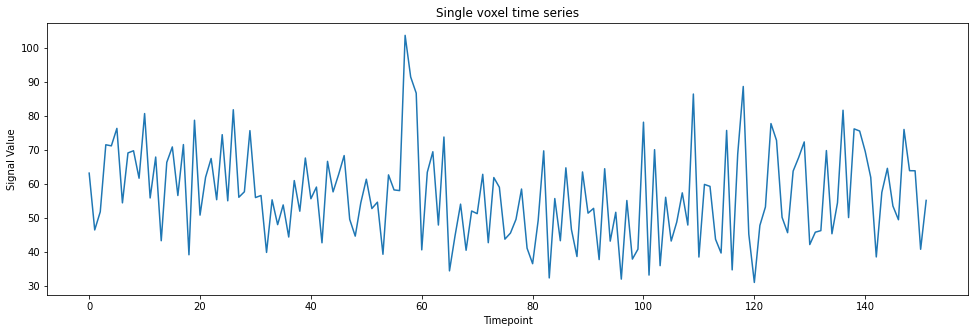

In [17]:
plot_ts(single_vox)

# 2.3 Parcellation

In [18]:
# Get resting state data (preprocessed, mask, and confounds file)
func_files = layout.get(datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        return_type='file')
func_files = extract_extension_files(func_files)

mask_files = layout.get(datatype='func', task='rest',
                        desc='brain',
                        suffix="mask",
                        space='MNI152NLin2009cAsym',
                        return_type='file')
mask_files = extract_extension_files(mask_files)

confound_files = layout.get(datatype='func',
                            task='rest',
                            desc='confounds',
                            return_type='file')
confound_files = extract_extension_files(confound_files, extension='tsv')

In [19]:
!tree ../resources/rois/

../resources/rois/
└── yeo_2011
    └── Yeo_JNeurophysiol11_MNI152
        ├── FSL_MNI152_FreeSurferConformed_1mm.nii.gz
        ├── relabeled_yeo_atlas.nii.gz
        ├── Yeo2011_17Networks_ColorLUT.txt
        ├── Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
        ├── Yeo2011_17Networks_MNI152_FreeSurferConformed1mm.nii.gz
        ├── Yeo2011_7Networks_ColorLUT.txt
        ├── Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
        ├── Yeo2011_7Networks_MNI152_FreeSurferConformed1mm.nii.gz
        └── Yeo_JNeurophysiol11_MNI152_README

2 directories, 9 files


<code>input_data</code> allows us to pull data using the parcellation file, and at the same time applying data cleaning

We first create the parcellation file <code>yeo_7</code> and our cleaning settings which are the following:

Settings to use:
- Confounds: trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, white_matter, csf, global_signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True


In [20]:
params = {
    'parcel_file': '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz',
    'confounds': ['trans_x', 'trans_y', 'trans_z', 
                  'rot_x', 'rot_y', 'rot_z', 
                  'white_matter', 'csf', 'global_signal'],
    'high_pass': 0.009,
    'low_pass': 0.08,
    'detrend': True,
    'standardize': True,
    'tr_drop': 4
    
}
experiment.log_parameters(params)

In [21]:
# Load separated parcellation
yeo_7 = nimg.load_img(params['parcel_file'])

The **input_data.NiftiLabelsMasker** object is a wrapper that applies parcellation, cleaning and averaging to an functional image. For example let's apply this to our first subject:

In [22]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=params['standardize'],
                                      memory='nilearn_cache',
                                      detrend=params['detrend'],
                                      low_pass=params['low_pass'],
                                      high_pass=params['high_pass'],
                                      t_r=2)

In [23]:
# Pull the first subject's data
func_file = func_files[0]
mask_file = func_mask_files[0]
confound_file = confound_files[0]

In [24]:
# Load func image
func_img = nimg.load_img(func_file)

# Remove the first 4 TRs
func_img = func_img.slicer[:,:,:,params['tr_drop']:]

# Use the above function to pull out a confound matrix
confounds = extract_confounds(confound_file,
                              params['confounds'])
# Drop the first 4 rows of the confounds matrix
confounds = confounds[params['tr_drop']:,:] 

In [25]:
# Apply cleaning, parcellation and extraction to functional data
cleaned_and_averaged_time_series = masker.fit_transform(func_img,confounds)
cleaned_and_averaged_time_series.shape

(148, 43)

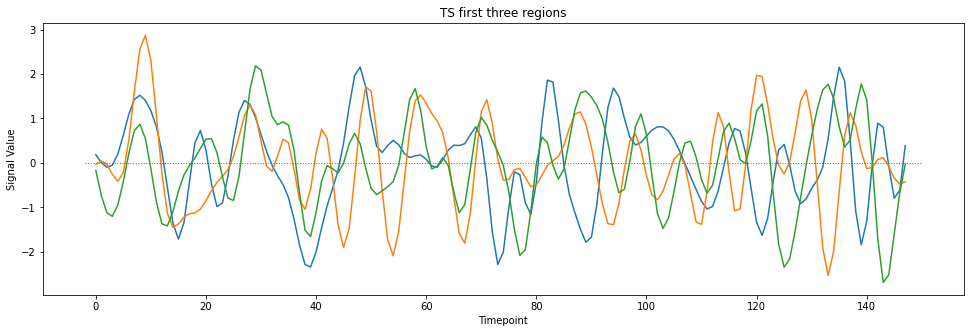

In [26]:
# Visualize ROIs Time Series
plot_ts(cleaned_and_averaged_time_series[:,0:3], 
        title='TS first three regions')
plt.hlines(0, -2, cleaned_and_averaged_time_series[:,0:3].shape[0]+2, 
           linewidth=1.0, linestyles="dotted")

In [27]:
# We expected 50 ROIs -> this means that 7 of our atlas' parcels did not correspond to any region with signal
print(masker.labels_)
print("Number of labels", len(masker.labels_))

[1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49]
Number of labels 43


In [28]:
# Get the label numbers from the atlas
atlas_labels = np.unique(yeo_7.get_fdata().astype(int))

# Get number of labels that we have
NUM_LABELS = len(atlas_labels)
print(f'Number of labels that we have in atlas: {NUM_LABELS}')

# fMRI images (x,y,z,t)
num_timepoints = func_img.shape[3]

# Create an array of zeros that has the correct size
final_signal = np.zeros((num_timepoints, NUM_LABELS))

# Get regions that are kept
regions_kept = np.array(masker.labels_)

# Fill columns matching labels with signal values
final_signal[:, regions_kept] = cleaned_and_averaged_time_series

print(f'Full parcells atlas {final_signal.shape}')

valid_regions_signal = final_signal[:, regions_kept]
print(f'Number of regions with valid signal: {valid_regions_signal.shape}')

np.array_equal(
    valid_regions_signal,
    cleaned_and_averaged_time_series
)

Number of labels that we have in atlas: 50
Full parcells atlas (148, 50)
Number of regions with valid signal: (148, 43)


True

# 3. Calculating Connectivity

In [29]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
full_correlation_matrix = correlation_measure.fit_transform([final_signal])

full_correlation_matrix.shape

(1, 50, 50)

In [30]:
# Correlation between ROIs 44 and 46
full_correlation_matrix[0, 43, 45]

0.00713201765539153

In [31]:
full_correlation_matrix[0, 45, 43]

0.00713201765539153

<AxesSubplot:>

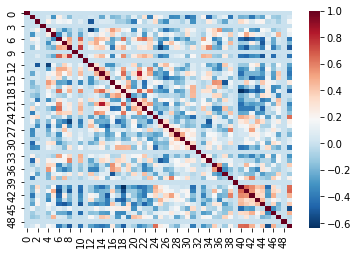

In [32]:
import seaborn as sns
sns.heatmap(full_correlation_matrix[0], cmap='RdBu_r')

In [33]:
experiment.log_confusion_matrix(matrix=full_correlation_matrix[0])

{'web': 'https://www.comet.ml/api/asset/download?assetId=54c75b3ec5d84c23828fbd544b54b343&experimentKey=77549b2bee0b4a0ca5149458712f5926',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=54c75b3ec5d84c23828fbd544b54b343&experimentKey=77549b2bee0b4a0ca5149458712f5926',
 'assetId': '54c75b3ec5d84c23828fbd544b54b343'}

# 4. All subjects

In [34]:
# Lsts to store time series for all regions
ctrl_subjects = []
schz_subjects = []

# Unfilled
ctrl_subjects_raw = []
schz_subjects_raw = []

# We're going to keep track of each of our subjects labels here
# pulled from masker.labels_
labels_list = []

# Get the number of unique labels in parcellation
atlas_labels = np.unique(yeo_7.get_fdata().astype(int))
NUM_LABELS = len(atlas_labels)


subjects = layout.get_subjects()
for sub in tqdm(subjects):
    
    # Get the functional file for the subject (MNI space)
    func_file = layout.get(subject=sub,
                           datatype='func', task='rest',
                           desc='preproc',
                           space='MNI152NLin2009cAsym',
                           return_type='file')
    func_file = extract_extension_files(func_file)[0]
    
    # Get the confounds file for the subject (MNI space)
    confound_file=layout.get(subject=sub, datatype='func',
                             task='rest',
                             desc='confounds',
                             return_type='file')
    confound_file = extract_extension_files(confound_file, extension='tsv')[0]

 
    #Load the functional file in
    func_img = nimg.load_img(func_file)
    
    #Drop the first 4 TRs
    func_img = func_img.slicer[:,:,:,params['tr_drop']:]
    
    
    #Extract the confound variables 
    confounds = extract_confounds(confound_file,
                                  params['confounds'])
    
    #Drop the first 4 rows from the confound matrix
    confounds = confounds[params['tr_drop']:,:]
    
    # Make our array of zeros to fill out
    # Number of rows should match number of timepoints
    # Number of columns should match the total number of regions
    fill_array = np.zeros((func_img.shape[3], NUM_LABELS))
    
    # Apply the parcellation + cleaning to our data
    time_series = masker.fit_transform(func_img,confounds)
    
    # Get the regions that were kept for this scan
    regions_kept = np.array(masker.labels_)
    
    # Fill the array, this is what we'll use
    # to make sure that all our array are of the same size
    fill_array[:, regions_kept] = time_series
    
    #If the subject ID starts with a "1" then they are control
    if sub.startswith('1'):
        ctrl_subjects.append(fill_array)
        ctrl_subjects_raw.append(time_series)
    #If the subject ID starts with a "5" then they are case (case of schizophrenia)
    if sub.startswith('5'):
        schz_subjects.append(fill_array)
        schz_subjects_raw.append(time_series)
        
    labels_list.append(masker.labels_)

print(f'There are {len(subjects)} subjects in general. \n\
The control group includes {np.array(ctrl_subjects).shape[0]} subjects \n\
The group of schizophrenics includes {np.array(schz_subjects).shape[0]} subjects')

  0%|                                                                                                                                                                                        | 0/17 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:486: UserWarning: Persisting input arguments took 1.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:08<00:00,  4.04s/it]

There are 17 subjects in general. 
The control group includes 7 subjects 
The group of schizophrenics includes 10 subjects


# 5. Metrics of functional connectivity

### 5.1 Pearson correlation

In [35]:
def plot_corr_matrices(matrices, title='Pearson'):
    """Plot three correlation matrices"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
    plt.suptitle(title + " correlation connectivity matrices")
    ax1.imshow(matrices[0])
    ax2.imshow(matrices[1])
    ax3.imshow(matrices[2])
    plt.show()

In [36]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

In [37]:
ctrl_subjects[0].shape

(148, 50)

In [38]:
R_ctrl = connectivity_correlation.fit_transform(ctrl_subjects)
print(f'Control group connectivity matrix shape {R_ctrl.shape}')

R_schz = connectivity_correlation.fit_transform(schz_subjects)
print(f'Control group connectivity matrix shape {R_schz.shape}')

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:333: RuntimeWarning: divide by zero encountered in true_divide
  diagonal = np.atleast_2d(1. / np.sqrt(np.diag(covariance)))
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:334: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


Control group connectivity matrix shape (7, 50, 50)
Control group connectivity matrix shape (10, 50, 50)


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:333: RuntimeWarning: divide by zero encountered in true_divide
  diagonal = np.atleast_2d(1. / np.sqrt(np.diag(covariance)))
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/connectome/connectivity_matrices.py:334: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


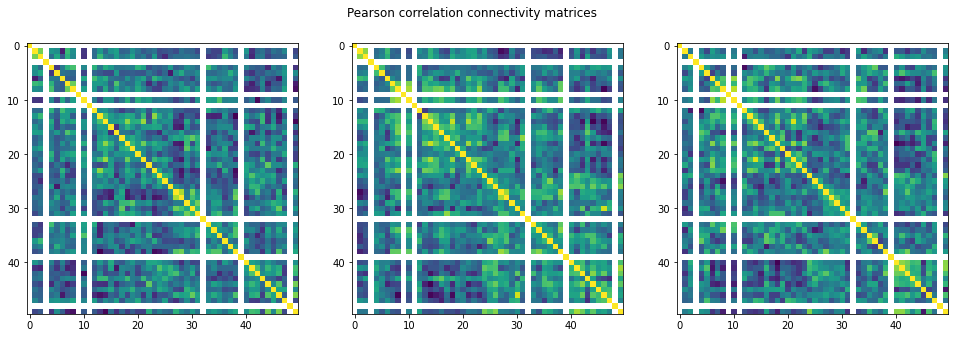

In [39]:
plot_corr_matrices(R_ctrl, 'Pearson')

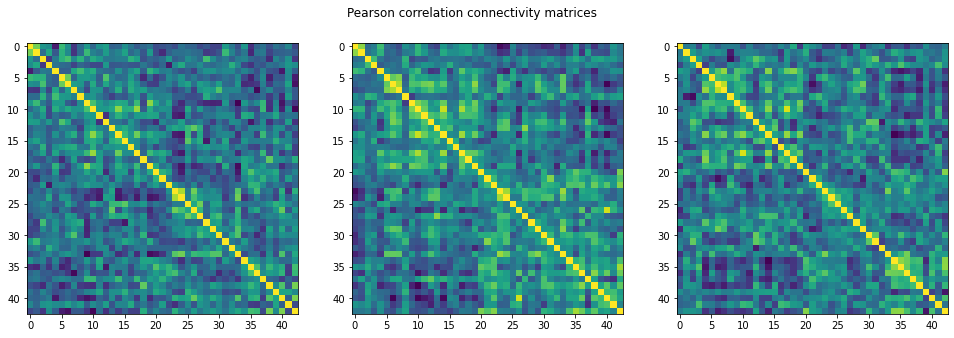

In [40]:
# Try to use raw labels
R_ctrl_raw = connectivity_correlation.fit_transform(ctrl_subjects_raw)
plot_corr_matrices(R_ctrl_raw, 'Pearson')

In [41]:
np.min(np.linalg.eigvalsh(R_ctrl_raw[0]))

3.801645215403821e-06

In [42]:
# Try to add Tikhonov normalization
lmbd = 0.01
R_reg = R_ctrl_raw[0] + lmbd * np.eye(R_ctrl_raw.shape[1])
np.min(np.linalg.eigvalsh(R_reg))

0.0100038016452154

## 5.2 Shrinkage estimators

Ledoit-Wolf

$$\tilde{\mathbf{C}}_X = (1 - \beta)\mathbf{C}_X + \alpha \beta \mathbf{I},~~~\alpha > 0, 0 \leq \beta \leq 1\\
\alpha = \frac{trace(\mathbf{C})}{n_{features}}$$

A well conditioned estimator for large dimensional covariance matrices, $\alpha$ is predefined according to formula, $\beta$ is inferred from data.

In [43]:
from sklearn.covariance import LedoitWolf

cov_estimator_shrinked = LedoitWolf()
connectivity_correlation_shrinked = ConnectivityMeasure(kind="correlation", cov_estimator=cov_estimator_shrinked)

In [44]:
# check the value of beta parameter
cov = cov_estimator_shrinked.fit(ctrl_subjects[0])
cov.shrinkage_

0.10351133001279911

In [45]:
R_shrinked = connectivity_correlation_shrinked.fit_transform(ctrl_subjects)

In [46]:
# checking the minimum eigenvalue
np.min(np.linalg.eigvalsh(R_shrinked[0]))

0.0903322089354568

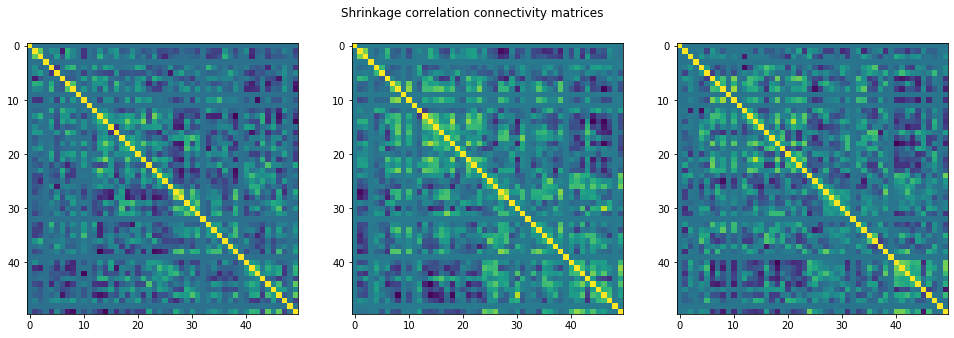

In [47]:
plot_corr_matrices(R_shrinked, 'Shrinkage')

## 5.3 Spearman correlation

In [48]:
# It doesn`t work
from scipy.stats import spearmanr

n_regions = ctrl_subjects[0].shape[1]
S = np.zeros((3, n_regions, n_regions))

for i in range(3):
    S[i], _ = spearmanr(ctrl_subjects[i])

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


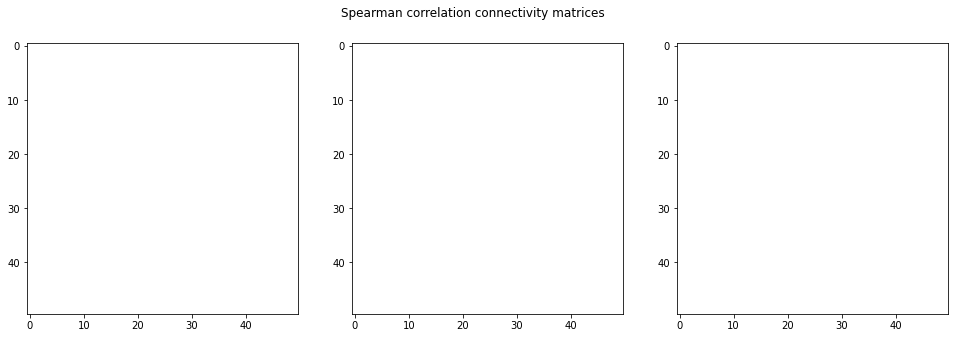

In [49]:
plot_corr_matrices(S, 'Spearman')

<AxesSubplot:>

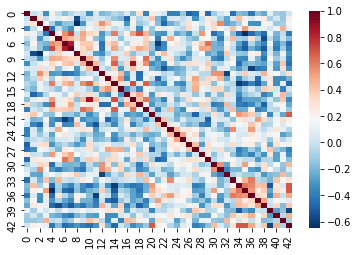

In [50]:
# As I understand it, this is because we have added unfilled regions
spearman_correlation_matrix = spearmanr(cleaned_and_averaged_time_series)
sns.heatmap(spearman_correlation_matrix[0], cmap='RdBu_r')

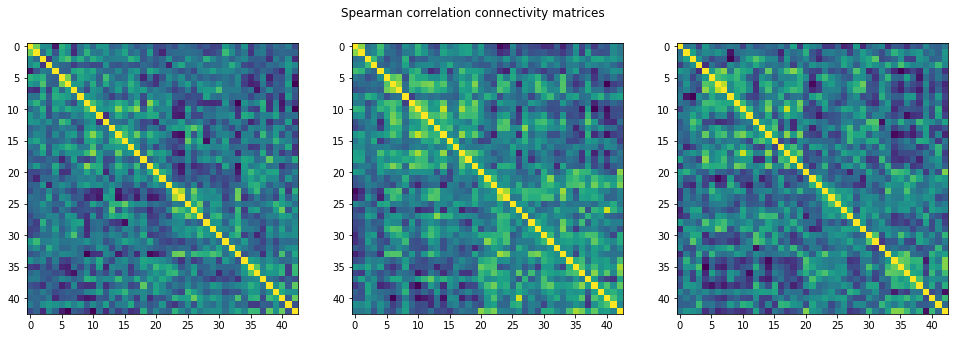

In [51]:
n_regions = ctrl_subjects_raw[0].shape[1]
S = np.zeros((3, n_regions, n_regions))

for i in range(3):
    S[i], _ = spearmanr(ctrl_subjects_raw[i])

plot_corr_matrices(S, 'Spearman')

## 5.4 Mutual information

Mutual information measures the information that random variables $X$ and $Y$ share, how much knowing one of these variables reduces uncertainty about the other. determined how different to joint distributon $p(X, Y)$ is to the production of the marginal distrubutions $p(X) p(Y)$.

$$I(X, Y) = \sum_{(x, y)} p(x, y) \log_2 \left( \frac{p(x, y)}{p(x)p(y)} \right)$$

In [52]:
ctrl_subjects[0].shape

(148, 50)

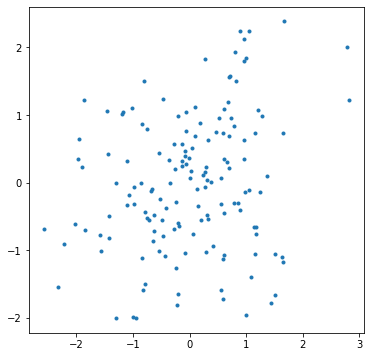

In [53]:
plt.figure(figsize=(6,6))
plt.plot(ctrl_subjects[0][:,1], ctrl_subjects[0][:,13], ".")

In [54]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def bound(x):
    return np.sqrt(1 - np.exp(-2 * x))

In [55]:
l = calc_MI(ctrl_subjects[0][:,1], ctrl_subjects[0][:,13])
l, bound(l)

(0.30179794966764345, 0.6731703286318633)

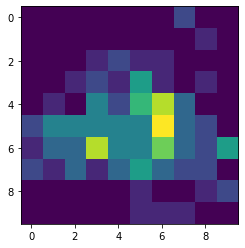

In [56]:
c_xy = np.rot90(np.histogram2d(ctrl_subjects[2][:,1], ctrl_subjects[2][:,13], 10)[0])
plt.imshow(c_xy)

In [57]:
%%time
M = np.zeros((3, n_regions, n_regions))

for k in range(3):
    for i in range(n_regions):
        for j in range(i, n_regions):
            M[k,i,j] = bound(calc_MI(ctrl_subjects[k][:,i], ctrl_subjects[k][:,j]))
            
    M[k] = M[k] + M[k].T
    np.fill_diagonal(M[k], 1)

CPU times: user 1.95 s, sys: 0 ns, total: 1.95 s
Wall time: 1.96 s


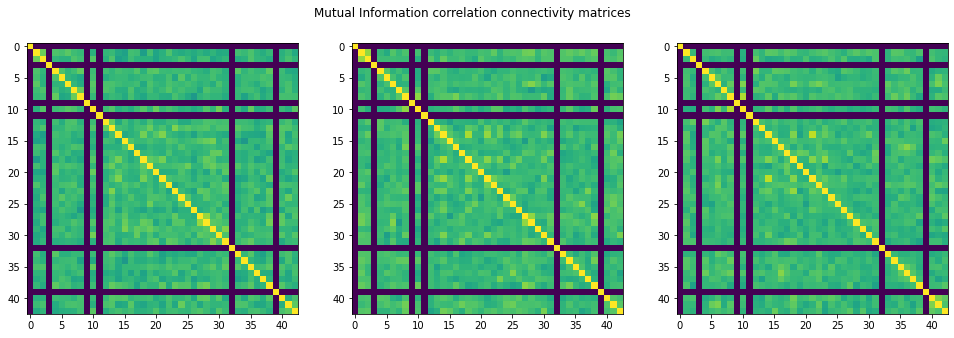

In [58]:
plot_corr_matrices(M, 'Mutual Information')

In [59]:
%%time
n_regions = ctrl_subjects_raw[0].shape[1]
M = np.zeros((3, n_regions, n_regions))

for k in range(3):
    for i in range(n_regions):
        for j in range(i, n_regions):
            M[k,i,j] = bound(calc_MI(ctrl_subjects_raw[k][:,i], ctrl_subjects_raw[k][:,j]))
            
    M[k] = M[k] + M[k].T
    np.fill_diagonal(M[k], 1)

CPU times: user 1.83 s, sys: 2.56 ms, total: 1.83 s
Wall time: 1.85 s


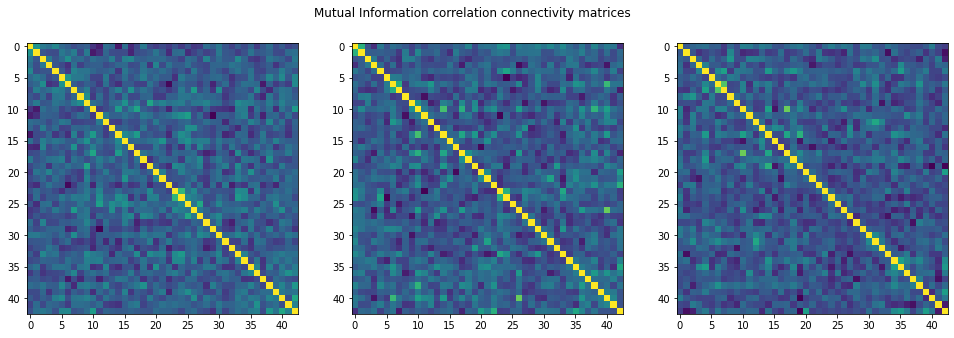

In [60]:
plot_corr_matrices(M, 'Mutual Information')

## 5.5 Thresholding

In [61]:
R_tresholded = R_shrinked[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0
R_tresholded

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.59518853, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.59518853, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

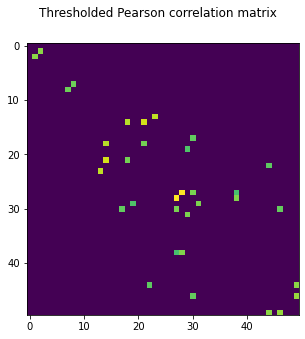

In [62]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

## Network visualization

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


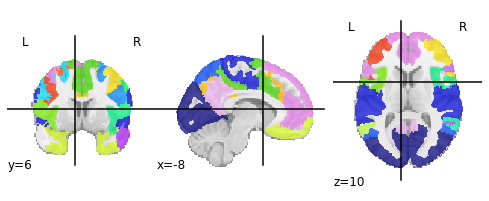

In [63]:
yeo_7 = nimg.load_img(params['parcel_file'])
nplot.plot_roi(yeo_7)

In [64]:
from nilearn import plotting

coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo_7)
print(coordinates.shape)

(49, 3)


In [65]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etokone/fmri-la5c-study/77549b2bee0b4a0ca5149458712f5926
COMET INFO:   Parameters:
COMET INFO:     assume_centered : False
COMET INFO:     block_size      : 1000
COMET INFO:     confounds       : ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'white_matter', 'csf', 'global_signal']
COMET INFO:     detrend         : True
COMET INFO:     high_pass       : 0.009
COMET INFO:     low_pass        : 0.08
COMET INFO:     parcel_file     : ../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz
COMET INFO:     standardize     : True
COMET INFO:     store_precision : True
COMET INFO:     tr_drop         : 4
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1


ValueError: Shape mismatch between 'adjacency_matrix' and 'node_coords''adjacency_matrix' shape is (50, 50), 'node_coords' shape is (49, 3)

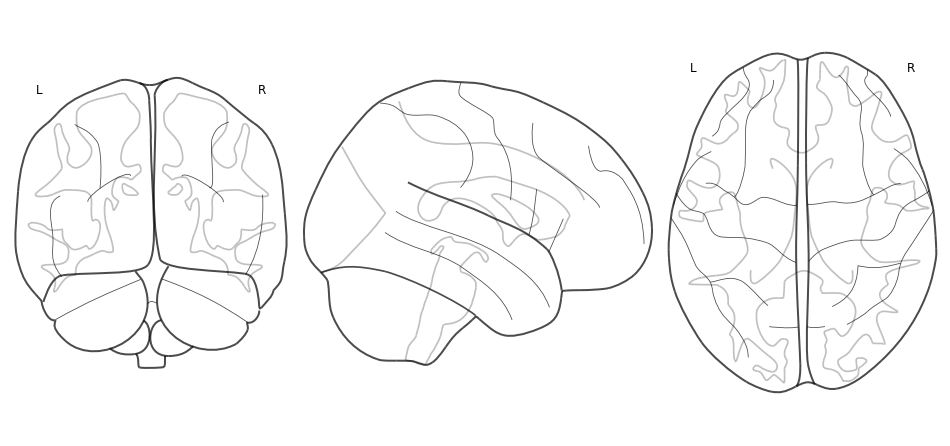

In [65]:
# dimensions cannot match!!
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
plotting.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

In [66]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etokone/fmri-la5c-study/89e778a43458473594f37cf7263ea28a
COMET INFO:   Parameters:
COMET INFO:     assume_centered : False
COMET INFO:     block_size      : 1000
COMET INFO:     confounds       : ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'white_matter', 'csf', 'global_signal']
COMET INFO:     detrend         : True
COMET INFO:     high_pass       : 0.009
COMET INFO:     low_pass        : 0.08
COMET INFO:     parcel_file     : ../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz
COMET INFO:     standardize     : True
COMET INFO:     store_precision : True
COMET INFO:     tr_drop         : 4
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1


KeyboardInterrupt: 